# 12bis Associate Ca2+ signal with sleep stages from multiple subsessions

load packages

In [308]:
import quantities as pq
import numpy as np
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer

from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

Load sleep score and Ca2+ time series numpy arrays

In [309]:
folder_base = Path('Gaelle/Baseline_recording/ThreeColDotsOK/')
session = 3
subsession = 4
numbsubsession = 4

folder_base2 = folder_base / f'session{session}/'
folder_Ephys = folder_base / f'session{session}/OpenEphys/'
folder_Minis = folder_base / f'session{session}/V4_Miniscope/session{session}{subsession}/minian/'

filenameE = folder_Ephys / f'ScoredSleep.npy'
SleepScoredTS = np.load(filenameE)
filenameB = folder_base2 / f'SynchroFile.xlsx'
stamps = pd.read_excel(filenameB)

dict_minian = {}
for x in range(1, numbsubsession+1):
    folder_MinisSess = folder_base2 / f'V4_Miniscope/session{session}{x}/minian'
    dict_minian["ds_minian{0}".format(x)] = open_minian(folder_MinisSess)


for file_path in folder_base2.glob('**/*timeStamps.csv'):
    subfolder = file_path.parents[0].stem
    if subfolder == 'V4_Miniscope':
        stamps_miniscope = pd.read_csv(file_path)

Acq_freq = (list(stamps[0])[2])

TodropFile = folder_Minis / f'TodropFile.json'
with open(TodropFile, 'r') as f:
    unit_to_drop = json.load(f)

#TodropFile = folder_Minis / f'TokeepFile.json'
#with open(TodropFile, 'r') as f:
#    unit_to_keep = json.load(f)

TodropFile = folder_Minis / f'AllunitsFile.json'
with open(TodropFile, 'r') as f:
    All_units = json.load(f)

UnitToKeepL = [e for e in All_units if e not in unit_to_drop]
#UnitToKeepL = [e for e in All_units if e in unit_to_keep]
#unit_to_drop = [e for e in All_units if e not in unit_to_keep]
UnitToKeepInd = [e for e, elem in enumerate(All_units) if elem in UnitToKeepL]
print(UnitToKeepL)
print(unit_to_drop)
print(All_units)


[30, 34, 36, 39, 52, 66, 78, 86]
[0, 2, 3, 5, 6, 8, 10, 12, 15, 16, 17, 21, 24, 25, 26, 27, 28, 29, 32, 35, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51, 53, 55, 56, 58, 60, 63, 69, 71, 73, 74, 75, 76, 77, 82, 83, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 107, 109, 110, 112, 114, 117, 118, 121, 123, 125, 127, 129, 130, 131, 132, 133, 134, 135, 137, 141, 143, 144, 145, 147, 148, 150, 152, 153, 154, 155, 156, 157, 159, 160, 161, 165, 166, 170, 171, 172, 174, 175, 178, 179, 181, 182, 183, 184, 185, 186, 188, 189, 190, 191, 192, 195, 196]
[0, 2, 3, 5, 6, 8, 10, 12, 15, 16, 17, 21, 24, 25, 26, 27, 28, 29, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 58, 60, 63, 66, 69, 71, 73, 74, 75, 76, 77, 78, 82, 83, 86, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 107, 109, 110, 112, 114, 117, 118, 121, 123, 125, 127, 129, 130, 131, 132, 133, 134, 135, 137, 141, 143, 144, 145, 147, 148, 150, 152, 153, 154, 155, 156, 1

Decide which session to analyse and assign the right files

In [310]:
# start time
StartTime1 = (list(stamps[0])[0])

# start time session 2
def Convert(string):
    li = list(string.split(", "))
    li2 = len(li)
    return li2
stri = stamps[0][3]

numbdropfr = Convert(stri)


from ast import literal_eval
list_droppedframes = literal_eval(stamps[0][3])


dict_StartTime = {}
dict_StartTime[1] = (list(stamps[0])[0])
dict_EndTime = {}
dict_RecDur = {}
for x in range(1, numbsubsession+1):
    folder_MinisSess = folder_base2 / f'V4_Miniscope/session{session}{x}/minian'
    minian_ds = open_minian(folder_MinisSess)
    C = minian_ds['S']
    dict_RecDur[x] = C.shape[1]
    if len(list_droppedframes) > 0:
        numbdropfr = len(list(item for item in range(numbdropfr) if list_droppedframes[item] < dict_RecDur[x]))
    else:
        numbdropfr = 0
    dict_EndTime[x] = dict_StartTime[x] + (dict_RecDur[x] + numbdropfr)/stamps[0][2]
    if x < numbsubsession:
        dict_StartTime[x+1] = dict_EndTime[x]

print(dict_StartTime)
print(dict_EndTime)
print(dict_RecDur)

{1: 2.67248, 2: 836.0058133333333, 3: 1702.67248, 4: 2536.005813333333}
{1: 836.0058133333333, 2: 1702.67248, 3: 2536.005813333333, 4: 3369.3391466666667}
{1: 25000, 2: 26000, 3: 25000, 4: 25000}


0 on closest matching time point.


In [311]:
StartTime = dict_StartTime[subsession]
EndTime = dict_EndTime[subsession]
rec_dur = dict_RecDur[subsession]
minian_ds = dict_minian[f"ds_minian{subsession}"]

# update start time of sleep scored time serie
P = round(StartTime)
multiple5 = [*range(0, 10000, 5)]
for ind in multiple5:
    if StartTime==ind:
        P = ind
        Pupd = int(P/5)
    elif (StartTime>ind) and (StartTime<(ind+5)):
        P = ind + 5
        Pupd = int(P/5)
SleepScoredTSupd = SleepScoredTS[Pupd:]

# update start time of Ca2+ imaging time series
First_frame = round((P - StartTime)*(list(stamps[0])[2]))
C = minian_ds['S']
Cupd = C.loc[:, First_frame:]
nb_unit = Cupd.shape[0]
rec_dur = Cupd.shape[1]
P

2540

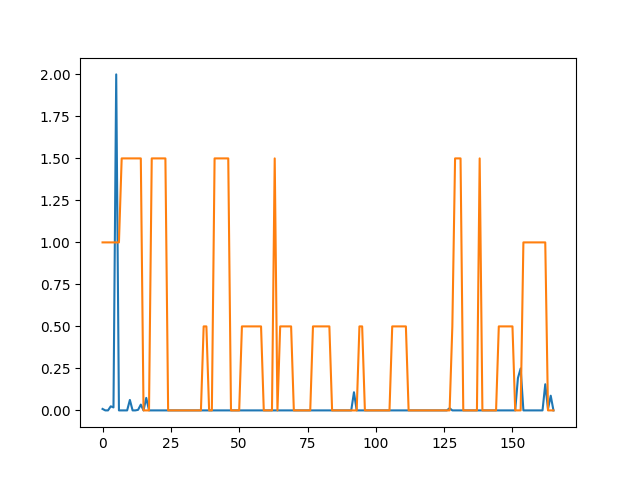

In [312]:
A = minian_ds['A']
B = A['unit_id']
copyB = list(B.copy())
for i in range(len(unit_to_drop)):
    elem = unit_to_drop[i]
    copyB.remove(elem)
unit_to_keep = copyB

C_upd = Cupd.loc[unit_to_keep,:]
nb_unit = C_upd.shape[0]

Test2 = C_upd.to_series()
unit = 0
lTest2 = np.array(Test2)[(unit)*rec_dur:(unit+1)*rec_dur]
input_arr = lTest2
R = round(len(lTest2)/(5*list(stamps[0])[2])) # 5 sec bins
split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)
dwnsmpl_subarr = np.split(input_arr, split_arr[1:])
dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )

SleepScoredTSupd2 = SleepScoredTSupd[:len(dwnsmpl_arrT)]
dwnsmpl_arrT2 = 2*dwnsmpl_arrT/max(dwnsmpl_arrT)
dwnsmpl_arrT2 = dwnsmpl_arrT2[0:len(SleepScoredTSupd)]

plt.close()
plt.plot(dwnsmpl_arrT2)
plt.plot(SleepScoredTSupd2)
plt.show()


In [313]:
data = {
    'Unit':np.zeros(nb_unit),
    'Wake' : np.zeros(nb_unit),
    'NREM' : np.zeros(nb_unit),
    'N2' : np.zeros(nb_unit),
    'REM' : np.zeros(nb_unit),
}
Activity_state = pd.DataFrame(data, columns=['Unit', 'Wake', 'NREM', 'N2', 'REM'])

for unit in range(nb_unit):
    lTest2 = np.array(Test2)[(unit)*rec_dur:(unit+1)*rec_dur]
    input_arr = lTest2
    R = round(len(lTest2)/(5*list(stamps[0])[2])) # 5 sec bins
    split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)
    dwnsmpl_subarr = np.split(input_arr, split_arr[1:])
    dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )
    dwnsmpl_arrT = dwnsmpl_arrT[0:len(SleepScoredTSupd)]
    for time_stamp in range(len(dwnsmpl_arrT2)):
        if(SleepScoredTSupd2[time_stamp] == 1):
            Activity_state["REM"][unit] = Activity_state["REM"][unit] + dwnsmpl_arrT[time_stamp]    
        elif(SleepScoredTSupd2[time_stamp] == 0.5):
            Activity_state["N2"][unit] = Activity_state["N2"][unit] + dwnsmpl_arrT[time_stamp]     
        elif(SleepScoredTSupd2[time_stamp] == 1.5):
            Activity_state["Wake"][unit] = Activity_state["Wake"][unit] + dwnsmpl_arrT[time_stamp]     
        elif(SleepScoredTSupd2[time_stamp] == 0):
            Activity_state["NREM"][unit] = Activity_state["NREM"][unit] + dwnsmpl_arrT[time_stamp]     

In [314]:
data = {
    'Wake' : np.zeros(2),
    'NREM' : np.zeros(2),
    'N2' : np.zeros(2),
    'REM' : np.zeros(2),
}
Activity_state_time = pd.DataFrame(data, columns=['Wake', 'NREM', 'N2', 'REM'])

for time_stamp in range(len(dwnsmpl_arrT)):
    if(SleepScoredTSupd2[time_stamp] == 1):
        Activity_state_time["REM"][0] = Activity_state_time["REM"][0] + 1   
    elif(SleepScoredTSupd2[time_stamp] == 0.5):
        Activity_state_time["N2"][0] = Activity_state_time["N2"][0] + 1
    elif(SleepScoredTSupd2[time_stamp] == 1.5):
        Activity_state_time["Wake"][0] = Activity_state_time["Wake"][0] + 1    
    elif(SleepScoredTSupd2[time_stamp] == 0):
        Activity_state_time["NREM"][0] = Activity_state_time["NREM"][0] + 1     

Activity_state_time["REM"][1] = Activity_state_time["REM"][0]/len(dwnsmpl_arrT)
Activity_state_time["N2"][1] = Activity_state_time["N2"][0]/len(dwnsmpl_arrT)
Activity_state_time["Wake"][1] = Activity_state_time["Wake"][0]/len(dwnsmpl_arrT)
Activity_state_time["NREM"][1] = Activity_state_time["NREM"][0]/len(dwnsmpl_arrT)
Activity_state_time.index = ['absolu', 'percentage']

# Double normalisation 1- by total fluorescence per cell 2- by time spent in each state.
Activity_state_n = Activity_state.copy()
row_sums = Activity_state_n.sum(axis=1)
Activity_state_n = Activity_state_n / row_sums[:, np.newaxis]
# % of fluorescence power observed relative to what would have been expected if intensity was uniformally distributed
RelativeWeight = round(Activity_state_n / Activity_state_time.loc['percentage'] * 100)
RelativeWeight.apply(np.sum, axis=0)/nb_unit

/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_19386/4170739846.py:28: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Activity_state_n = Activity_state_n / row_sums[:, np.newaxis]


N2       60.125
NREM     68.500
REM     357.875
Unit      0.000
Wake    104.250
dtype: float64

In [315]:
#filenameUnit = folder_sessionMini / f'UnitToKeep.xlsx'
#unitname = pd.read_excel(filenameUnit)
RelativeWeight['Unit'] = UnitToKeepL

filenameOut = folder_Minis / f'SpikeVigilanceStates.xlsx'
writer = pd.ExcelWriter(filenameOut)
RelativeWeight.to_excel(writer)
writer.save()

In [316]:
data = {
    'Unit':np.zeros(nb_unit),
    'Wake' : np.zeros(nb_unit),
    'NREM' : np.zeros(nb_unit),
    'N2' : np.zeros(nb_unit),
    'REM' : np.zeros(nb_unit),
}
Activity_state_frame = pd.DataFrame(data, columns=['Unit', 'Wake', 'NREM', 'N2', 'REM'])

for unit in [1,2]:#range(nb_unit):
    lTest2 = np.array(Test2)[(unit)*rec_dur:(unit+1)*rec_dur]
    input_arr = lTest2
    R = round(len(lTest2)/(5*list(stamps[0])[2])) # 5 sec bins
    split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)
    dwnsmpl_subarr = np.split(input_arr, split_arr[1:])
    dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )
    dwnsmpl_arrT = dwnsmpl_arrT[0:len(SleepScoredTSupd)]
    for time_stamp in range(len(dwnsmpl_arrT)):
        if((SleepScoredTSupd2[time_stamp] == 1) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["REM"][unit] = Activity_state_frame["REM"][unit] + 1    
        elif((SleepScoredTSupd2[time_stamp] == 0.5) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["N2"][unit] = Activity_state_frame["N2"][unit] + 1    
        elif((SleepScoredTSupd2[time_stamp] == 1.5) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["Wake"][unit] = Activity_state_frame["Wake"][unit] + 1     
        elif((SleepScoredTSupd2[time_stamp] == 0) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["NREM"][unit] = Activity_state_frame["NREM"][unit] + 1     

# Double normalisation 1- by total fluorescence per cell 2- by time spent in each state.
Activity_state_frame_n = Activity_state_frame.copy()
Activity_state_frame_n.apply(np.sum, axis=1)
row_sums_frame = Activity_state_frame_n.sum(axis=1)
Activity_state_frame_n = Activity_state_frame_n / row_sums_frame[:, np.newaxis]
# % of fluorescence power observed relative to what would have been expected if intensity was uniformally distributed
RelativeWeight_frame = round(Activity_state_frame_n / Activity_state_time.loc['percentage'] * 100)

RelativeWeight_frame.apply(np.sum, axis=0)/nb_unit

/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_19386/101019343.py:32: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Activity_state_frame_n = Activity_state_frame_n / row_sums_frame[:, np.newaxis]


N2      17.375
NREM    24.125
REM     31.875
Unit     0.000
Wake    35.000
dtype: float64

In [317]:
filenameOut = folder_Minis / f'NumFrameNormalisedVigilanceStates.xlsx'
writer = pd.ExcelWriter(filenameOut)
RelativeWeight_frame.to_excel(writer)
writer.save()

In [318]:
Activity_state_time

,Wake,NREM,N2,REM
absolu,25.000000,88.00000,37.000000,16.000000
percentage,0.150602,0.53012,0.222892,0.096386
